[View in Colaboratory](https://colab.research.google.com/github/arpitsharma9/01_machine_learning/blob/master/02_cnn/cifar10_augmentation_tpu_1.0.ipynb)

# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

---

In this notebook, we train a CNN on augmented images from the CIFAR-10 database.

### 1. Load CIFAR-10 Database

In [0]:
## https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

import os
from time import time
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf

In [195]:
# check tensorflow version, we want the one that support eager mode
print(tf.__version__)

# Check if eager execution mode is on
tf.executing_eagerly()

1.12.0-rc1


False

In [196]:
from tensorflow.keras.datasets import cifar10

# load the pre-shuffled train and test data
(x_train_full, y_train_full),(x_test, y_test) = cifar10.load_data()

print('x_train shape:', x_train_full.shape)
print(x_train_full.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [197]:
# create validation set
split = 0.2
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42)
print('x_train: {}, y_train: {}, x_val: {}, y_val: {}'
      .format(x_train.shape, y_train.shape, x_val.shape, y_val.shape))

x_train: (40000, 32, 32, 3), y_train: (40000, 1), x_val: (10000, 32, 32, 3), y_val: (10000, 1)


In [0]:
## define some variables
batch_size = 1024
num_classes = 10
epochs = 100
data_augmentation = True
#data_augmentation = False
num_predictions = 10
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_cifar10_trained_model.h5'

### 2. Visualize the First 36 Training Images

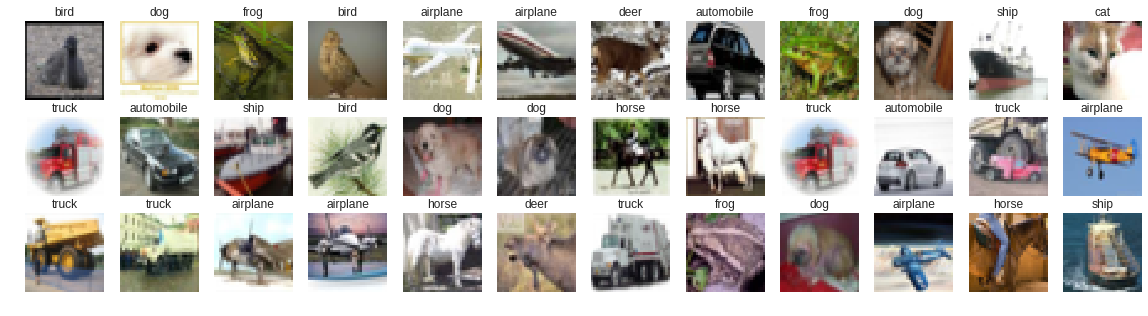

In [199]:
# pick 36 random images and plot
idxs = np.random.randint(x_train.shape[0], size=36)
images = x_train[idxs]
labels = y_train[idxs]
classnames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(3,12, figsize=(20,5))
#print(type(axes)) - there would be 36 elements in this numpy array - 3*12= 36 ... 3- row, 12 - column
## numpy.ndarray.flat¶ - A 1-D iterator over the array.
for i, ax in enumerate(axes.flat):
  ax.imshow(images[i])
  ax.axis('off')
  idx = labels[i][0]
  ax.set_title(classnames[idx])

plt.show()

### 3. Rescale the Images by Dividing Every Pixel in Every Image by 255

In [0]:
# rescale [0,255] --> [0,1]
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255 

### 4.  Break Dataset into Training, Testing, and Validation Sets

In [201]:
import tensorflow.keras.utils as util

# break training set into training and validation sets
(x_train, x_valid) = x_train_full[5000:], x_train_full[:5000]
(y_train, y_valid) = y_train_full[5000:], y_train_full[:5000]

# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = util.to_categorical(y_train, num_classes)
y_test = util.to_categorical(y_test, num_classes)
y_valid = util.to_categorical(y_valid, num_classes)

# print shape of training set
print('x_train shape:', x_train.shape)

# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (45000, 32, 32, 3)
45000 train samples
10000 test samples
5000 validation samples


### 5. Create and Configure Augmented Image Generator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    ) 

# fit augmented image generator on data
datagen_train.fit(x_train)

# this is the augmentation configuration we will use for testing:
# only rescaling
datagen_test = ImageDataGenerator(rescale=1. / 255)

### 6. Visualize Original and Augmented Images

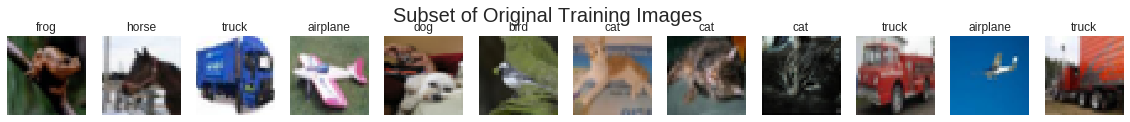

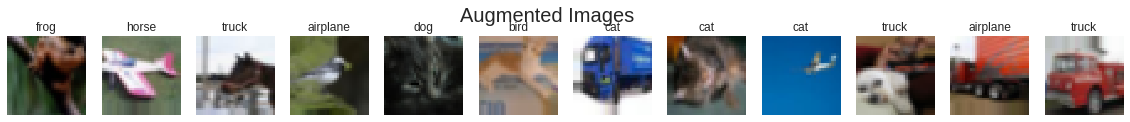

In [203]:
import matplotlib.pyplot as plt

# take subset of training data
x_train_subset = x_train[:12]
y_labels = np.argmax(y_train[:12].astype(int),axis=1)
#print(y_labels)

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1,xticks=[],yticks=[])
    ax.imshow(x_train_subset[i])
    idx = y_labels[i]
    ax.set_title(classnames[idx])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(x_train_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1,xticks=[],yticks=[])
        ax.imshow(x_batch[i])
        idx = y_labels[i]
        ax.set_title(classnames[idx])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### 7. Define the Model Architecture 

In [204]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation, Flatten, Dense, Dropout



model = Sequential()
model.add(Conv2D(32, (3, 3),padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 64)          18496     
__________

### 8. Compile the Model 

In [205]:
import os
import pprint

## not using TPU's
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  # This address identifies the TPU we'll use when configuring TensorFlow.
  #TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']  
  #print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  #print('TPU devices:')
  #pprint.pprint(devices)
  

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu_address)
    )
)

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.111.182.2:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 16565589576955605615)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7424499030029736918)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 6862969505888489031)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14036471808624493826)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 13469404899548093236)
INFO:tensorflow:*** Available Device: _Devic

In [0]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['categorical_accuracy'])

tpu_model.compile(
    #optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    optimizer=tf.train.RMSPropOptimizer(learning_rate=0.0001, decay=1e-6),
    #optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['categorical_accuracy']
)

### 9. Train the Model 

In [218]:
from tensorflow.keras.callbacks import ModelCheckpoint   

batch_size = 1024
epochs = 100
start = time()
# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist=model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer],
                    validation_data=(x_valid, y_valid),
                    validation_steps=x_valid.shape[0] // batch_size,verbose=1)

end = time()

Epoch 1/100
42/43 [============================>.] - ETA: 0s - loss: 1.4485 - categorical_accuracy: 0.4871
Epoch 00001: val_loss improved from inf to 9.03024, saving model to aug_model.weights.best.hdf5
43/43 [==============================] - 19s 449ms/step - loss: 1.4477 - categorical_accuracy: 0.4873 - val_loss: 9.0302 - val_categorical_accuracy: 0.4312
Epoch 2/100
42/43 [============================>.] - ETA: 0s - loss: 1.4025 - categorical_accuracy: 0.5044
Epoch 00002: val_loss improved from 9.03024 to 8.83831, saving model to aug_model.weights.best.hdf5
43/43 [==============================] - 19s 441ms/step - loss: 1.4047 - categorical_accuracy: 0.5037 - val_loss: 8.8383 - val_categorical_accuracy: 0.4424
Epoch 3/100
42/43 [============================>.] - ETA: 0s - loss: 1.3731 - categorical_accuracy: 0.5140
Epoch 00003: val_loss improved from 8.83831 to 8.47631, saving model to aug_model.weights.best.hdf5
43/43 [==============================] - 19s 433ms/step - loss: 1.3705 

In [221]:
print('Total training time {} seconds'.format(end - start))

Total training time 1876.5561664104462 seconds


### 10. Load the Model with the Best Validation Accuracy

In [0]:
# load the weights that yielded the best validation accuracy
#tpu_model.load_weights('aug_model.weights.best.hdf5')
model.load_weights('aug_model.weights.best.hdf5')

### 11. Calculate Classification Accuracy on Test Set

In [223]:
# evaluate and print test accuracy
#score = tpu_model.evaluate(x_test, y_test, verbose=1)
score = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test accuracy:', score[1])

10000/10000 [==============================] - 2s 245us/step

 Test accuracy: 0.718


### 12. Visualize Some Predictions

This may give you some insight into why the network is misclassifying certain objects.


In [0]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
  
  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])
  
  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])
    
  plt.show()
  
#print(hist.history)

### 12.1 Plot Loss and Accuracy

Lets see how did we do on training and validation sets

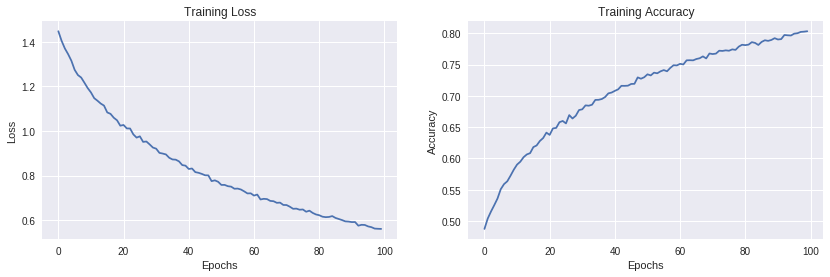

In [225]:
# Training
plot(hist.history['loss'], 
     #hist.history['sparse_categorical_accuracy'], 
     hist.history['categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

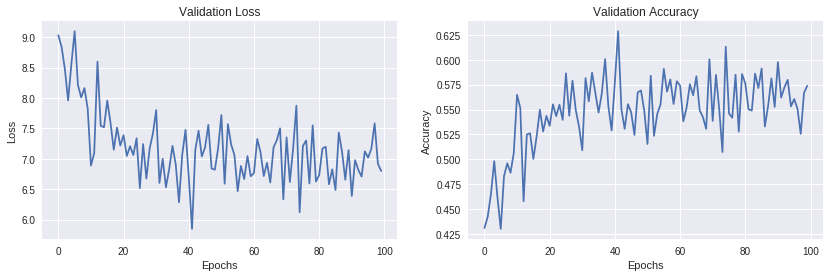

In [226]:
# Validation
plot(hist.history['val_loss'], 
     #hist.history['val_sparse_categorical_accuracy'], 
     hist.history['val_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )

### 13. Test accuracy

Next, we plot the model predictions on test *set*

In [0]:
#cpu_model = tpu_model.sync_to_cpu()

In [228]:
# get predictions on the test set
y_hat = cpu_model.predict(x_test)
#y_test_c = tf.keras.utils.to_categorical(y_test, num_classes)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#y_hat[0]*100 - max probabilty for cat.
#y_test[0] - cat
np.argmax(y_hat[0])
print(y_hat[0],y_test[0])



[0.02808366 0.03941654 0.03478014 0.38131866 0.01393426 0.32974607
 0.09727361 0.01142773 0.05103407 0.01298532] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


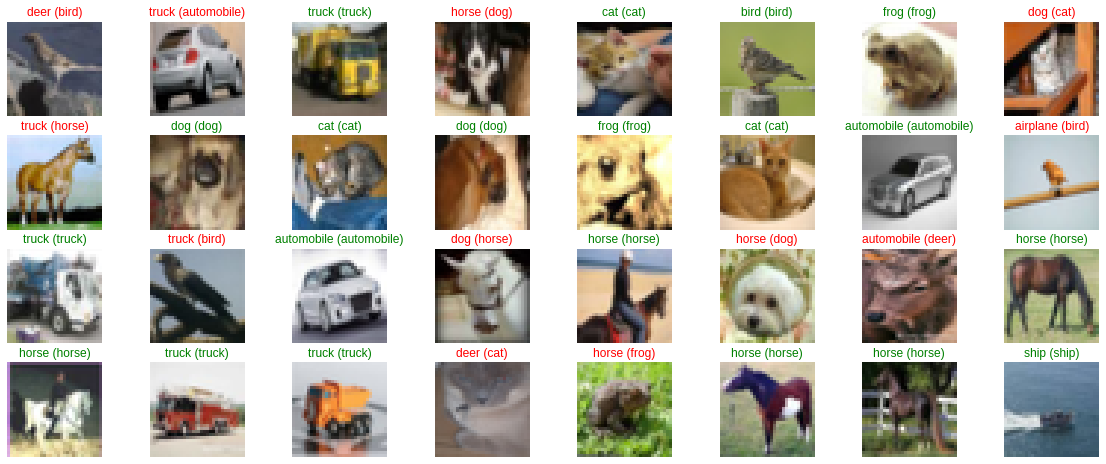

In [229]:
# plot a random sample of test images, their predicted labels, and ground truth
##x_test.shape[0] - basically i get the number of samples in testset.. i.e 10,000
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ## argmax will returns the indices of the maximum values along an axis.
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

### 14. Test accuracy

Next, we plot the model predictions on test *set**

https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

In [0]:
#https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d